# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0k/60.0k [00:09<00:00, 6.20kFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

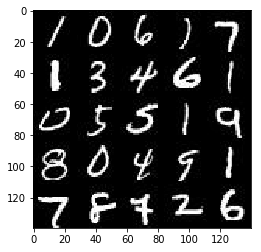

In [4]:
show_n_images = 25
import numpy as np

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(np.array(helper.images_square_grid(mnist_images, 'L')), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

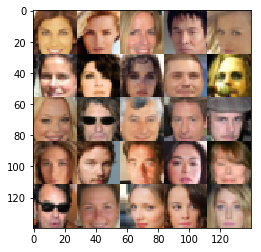

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.5.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [138]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=())

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [139]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    k_init = tf.random_normal_initializer(stddev=0.02)
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=k_init, padding='same')
        relu1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, kernel_initializer=k_init, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha*bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, kernel_initializer=k_init, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha*bn3, bn3)
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [ ]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    k_init = tf.random_normal_initializer(stddev=0.02)
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        bn1 = tf.layers.batch_normalization(x1, training=True)
        relu1 = tf.maximum(alpha*bn1, bn1)
        
        x2 = tf.layers.conv2d_transpose(relu1, 128, 5, strides=2, kernel_initializer=k_init, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha*bn2, bn2)
        
        x3 = tf.layers.conv2d_transpose(relu2, 64, 5, strides=2, kernel_initializer=k_init, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha*bn3, bn3)
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 3, strides=1, kernel_initializer=k_init, padding='same')
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [193]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False ,alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    smooth = 0.1
    real_labels = tf.ones_like(d_model_real) * (1 - smooth)
    fake_labels = tf.zeros_like(d_model_fake)
    g_labels = tf.ones_like(d_model_fake)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=real_labels))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=fake_labels))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=g_labels))
    
    d_loss = d_loss_real + d_loss_fake
        
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [194]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]

    with tf.control_dependencies(d_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
            
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [195]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(np.array(images_grid), cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [205]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
         print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=0.2)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0544... Generator Loss: 0.8602
Epoch 1/2... Discriminator Loss: 1.1108... Generator Loss: 0.8704
Epoch 1/2... Discriminator Loss: 0.9648... Generator Loss: 0.9942
Epoch 1/2... Discriminator Loss: 1.1597... Generator Loss: 0.6490
Epoch 1/2... Discriminator Loss: 0.9884... Generator Loss: 1.3146
Epoch 1/2... Discriminator Loss: 0.9205... Generator Loss: 1.0536
Epoch 1/2... Discriminator Loss: 0.8435... Generator Loss: 2.3062
Epoch 1/2... Discriminator Loss: 0.8018... Generator Loss: 1.8843
Epoch 1/2... Discriminator Loss: 0.9884... Generator Loss: 1.0858
Epoch 1/2... Discriminator Loss: 1.0618... Generator Loss: 1.6033


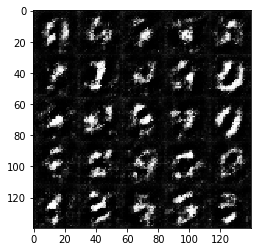

Epoch 1/2... Discriminator Loss: 0.9762... Generator Loss: 1.6425
Epoch 1/2... Discriminator Loss: 1.4271... Generator Loss: 0.4828
Epoch 1/2... Discriminator Loss: 1.0520... Generator Loss: 1.0588
Epoch 1/2... Discriminator Loss: 1.1133... Generator Loss: 1.7964
Epoch 1/2... Discriminator Loss: 1.0400... Generator Loss: 0.9000
Epoch 1/2... Discriminator Loss: 1.0335... Generator Loss: 1.8656
Epoch 1/2... Discriminator Loss: 1.0051... Generator Loss: 1.2334
Epoch 1/2... Discriminator Loss: 0.9903... Generator Loss: 1.2650
Epoch 1/2... Discriminator Loss: 1.0622... Generator Loss: 0.8325
Epoch 1/2... Discriminator Loss: 1.0948... Generator Loss: 0.7436


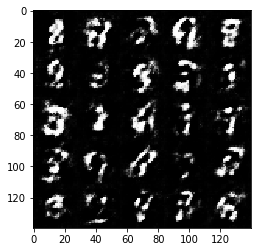

Epoch 1/2... Discriminator Loss: 0.9762... Generator Loss: 1.0865
Epoch 1/2... Discriminator Loss: 1.0302... Generator Loss: 1.5944
Epoch 1/2... Discriminator Loss: 1.0571... Generator Loss: 1.2030
Epoch 1/2... Discriminator Loss: 1.0373... Generator Loss: 1.0251
Epoch 1/2... Discriminator Loss: 1.0131... Generator Loss: 1.1059
Epoch 1/2... Discriminator Loss: 1.2247... Generator Loss: 0.6634
Epoch 1/2... Discriminator Loss: 0.8975... Generator Loss: 1.1617
Epoch 1/2... Discriminator Loss: 0.9751... Generator Loss: 1.4226
Epoch 1/2... Discriminator Loss: 0.8622... Generator Loss: 1.6079
Epoch 1/2... Discriminator Loss: 0.8163... Generator Loss: 1.4251


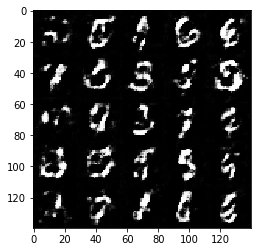

Epoch 1/2... Discriminator Loss: 1.0013... Generator Loss: 0.8869
Epoch 1/2... Discriminator Loss: 0.9123... Generator Loss: 1.0534
Epoch 1/2... Discriminator Loss: 0.8830... Generator Loss: 1.2830
Epoch 1/2... Discriminator Loss: 0.9364... Generator Loss: 0.9643
Epoch 1/2... Discriminator Loss: 0.8588... Generator Loss: 1.1815
Epoch 1/2... Discriminator Loss: 0.7555... Generator Loss: 1.4106
Epoch 1/2... Discriminator Loss: 0.7432... Generator Loss: 1.5367
Epoch 1/2... Discriminator Loss: 0.7967... Generator Loss: 1.5575
Epoch 1/2... Discriminator Loss: 0.7455... Generator Loss: 1.2864
Epoch 1/2... Discriminator Loss: 0.9284... Generator Loss: 1.0012


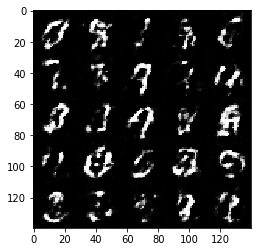

Epoch 1/2... Discriminator Loss: 0.8081... Generator Loss: 1.8029
Epoch 1/2... Discriminator Loss: 0.7472... Generator Loss: 1.7507
Epoch 1/2... Discriminator Loss: 0.7769... Generator Loss: 1.3557
Epoch 1/2... Discriminator Loss: 0.7900... Generator Loss: 1.4563
Epoch 1/2... Discriminator Loss: 0.6637... Generator Loss: 1.8106
Epoch 1/2... Discriminator Loss: 0.6808... Generator Loss: 1.7370
Epoch 1/2... Discriminator Loss: 0.6961... Generator Loss: 2.1248
Epoch 1/2... Discriminator Loss: 0.6771... Generator Loss: 2.0997
Epoch 1/2... Discriminator Loss: 0.7072... Generator Loss: 1.4269
Epoch 1/2... Discriminator Loss: 0.7933... Generator Loss: 1.2802


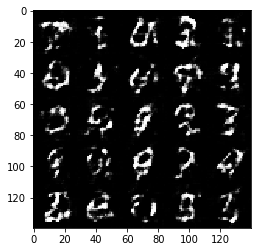

Epoch 1/2... Discriminator Loss: 0.6882... Generator Loss: 2.1642
Epoch 1/2... Discriminator Loss: 0.6423... Generator Loss: 1.8937
Epoch 1/2... Discriminator Loss: 0.8662... Generator Loss: 1.1094
Epoch 1/2... Discriminator Loss: 0.7069... Generator Loss: 2.2191
Epoch 1/2... Discriminator Loss: 0.7110... Generator Loss: 1.5746
Epoch 1/2... Discriminator Loss: 0.6971... Generator Loss: 1.7190
Epoch 1/2... Discriminator Loss: 0.7009... Generator Loss: 1.5823
Epoch 1/2... Discriminator Loss: 0.7506... Generator Loss: 1.9104
Epoch 1/2... Discriminator Loss: 0.9314... Generator Loss: 0.9976
Epoch 1/2... Discriminator Loss: 0.7904... Generator Loss: 1.2736


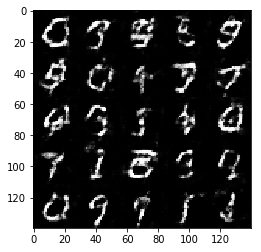

Epoch 1/2... Discriminator Loss: 0.9403... Generator Loss: 0.9402
Epoch 1/2... Discriminator Loss: 0.7406... Generator Loss: 1.7252
Epoch 1/2... Discriminator Loss: 0.8047... Generator Loss: 1.3592
Epoch 1/2... Discriminator Loss: 0.7462... Generator Loss: 1.3653
Epoch 1/2... Discriminator Loss: 0.8207... Generator Loss: 1.4184
Epoch 1/2... Discriminator Loss: 0.9320... Generator Loss: 1.6951
Epoch 1/2... Discriminator Loss: 0.8320... Generator Loss: 1.3842
Epoch 1/2... Discriminator Loss: 0.8854... Generator Loss: 1.7706
Epoch 1/2... Discriminator Loss: 0.8248... Generator Loss: 1.2104
Epoch 1/2... Discriminator Loss: 0.9906... Generator Loss: 0.9436


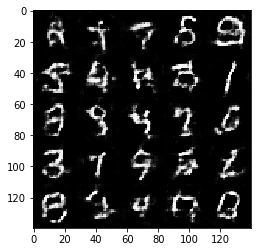

Epoch 1/2... Discriminator Loss: 0.8404... Generator Loss: 1.8065
Epoch 1/2... Discriminator Loss: 1.2171... Generator Loss: 2.7510
Epoch 1/2... Discriminator Loss: 0.8974... Generator Loss: 1.0754
Epoch 1/2... Discriminator Loss: 0.8886... Generator Loss: 0.9816
Epoch 1/2... Discriminator Loss: 0.8744... Generator Loss: 1.6437
Epoch 1/2... Discriminator Loss: 0.8284... Generator Loss: 1.1968
Epoch 1/2... Discriminator Loss: 0.9001... Generator Loss: 1.3807
Epoch 1/2... Discriminator Loss: 0.9214... Generator Loss: 1.1729
Epoch 1/2... Discriminator Loss: 1.1091... Generator Loss: 0.7485
Epoch 1/2... Discriminator Loss: 0.9897... Generator Loss: 0.9176


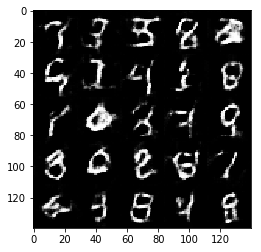

Epoch 1/2... Discriminator Loss: 0.9507... Generator Loss: 0.9504
Epoch 1/2... Discriminator Loss: 0.8430... Generator Loss: 1.5678
Epoch 1/2... Discriminator Loss: 0.8535... Generator Loss: 1.1637
Epoch 1/2... Discriminator Loss: 0.8652... Generator Loss: 1.2442
Epoch 1/2... Discriminator Loss: 0.8496... Generator Loss: 1.1853
Epoch 1/2... Discriminator Loss: 0.8688... Generator Loss: 1.5627
Epoch 1/2... Discriminator Loss: 0.7796... Generator Loss: 1.4559
Epoch 1/2... Discriminator Loss: 0.9084... Generator Loss: 1.2466
Epoch 1/2... Discriminator Loss: 0.8292... Generator Loss: 1.3609
Epoch 1/2... Discriminator Loss: 0.8673... Generator Loss: 1.3995


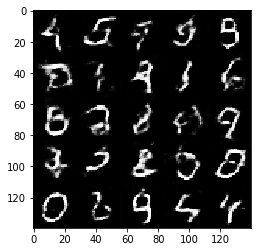

Epoch 1/2... Discriminator Loss: 1.0558... Generator Loss: 2.2240
Epoch 1/2... Discriminator Loss: 0.9194... Generator Loss: 1.2177
Epoch 1/2... Discriminator Loss: 0.7671... Generator Loss: 1.5682
Epoch 2/2... Discriminator Loss: 0.8735... Generator Loss: 2.0293
Epoch 2/2... Discriminator Loss: 0.8001... Generator Loss: 1.8021
Epoch 2/2... Discriminator Loss: 0.8877... Generator Loss: 1.0578
Epoch 2/2... Discriminator Loss: 0.8253... Generator Loss: 1.3451
Epoch 2/2... Discriminator Loss: 1.0392... Generator Loss: 0.8701
Epoch 2/2... Discriminator Loss: 0.8867... Generator Loss: 1.8175
Epoch 2/2... Discriminator Loss: 0.8332... Generator Loss: 1.7157


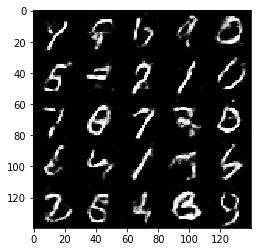

Epoch 2/2... Discriminator Loss: 0.9110... Generator Loss: 1.1171
Epoch 2/2... Discriminator Loss: 0.8824... Generator Loss: 1.1405
Epoch 2/2... Discriminator Loss: 0.8308... Generator Loss: 1.7407
Epoch 2/2... Discriminator Loss: 0.9050... Generator Loss: 1.9422
Epoch 2/2... Discriminator Loss: 0.7871... Generator Loss: 1.4633
Epoch 2/2... Discriminator Loss: 1.0412... Generator Loss: 0.8416
Epoch 2/2... Discriminator Loss: 0.8889... Generator Loss: 1.0704
Epoch 2/2... Discriminator Loss: 0.8748... Generator Loss: 1.0774
Epoch 2/2... Discriminator Loss: 0.8752... Generator Loss: 1.4996
Epoch 2/2... Discriminator Loss: 0.8374... Generator Loss: 1.4630


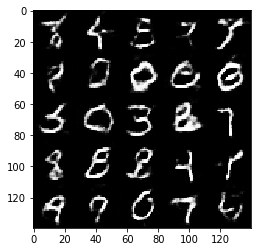

Epoch 2/2... Discriminator Loss: 0.7421... Generator Loss: 1.5893
Epoch 2/2... Discriminator Loss: 0.8178... Generator Loss: 1.3165
Epoch 2/2... Discriminator Loss: 0.8583... Generator Loss: 1.4065
Epoch 2/2... Discriminator Loss: 1.0611... Generator Loss: 0.7475
Epoch 2/2... Discriminator Loss: 0.8975... Generator Loss: 1.1311
Epoch 2/2... Discriminator Loss: 0.8258... Generator Loss: 1.4418
Epoch 2/2... Discriminator Loss: 0.9033... Generator Loss: 1.0240
Epoch 2/2... Discriminator Loss: 0.7725... Generator Loss: 1.6973
Epoch 2/2... Discriminator Loss: 0.8381... Generator Loss: 1.2712
Epoch 2/2... Discriminator Loss: 0.8137... Generator Loss: 1.4391


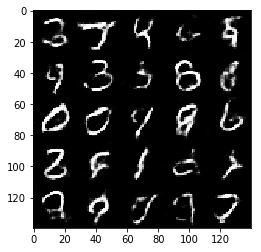

Epoch 2/2... Discriminator Loss: 0.9163... Generator Loss: 1.0017
Epoch 2/2... Discriminator Loss: 0.8044... Generator Loss: 1.7449
Epoch 2/2... Discriminator Loss: 0.8993... Generator Loss: 1.4527
Epoch 2/2... Discriminator Loss: 0.8005... Generator Loss: 1.8796
Epoch 2/2... Discriminator Loss: 0.8713... Generator Loss: 1.1002
Epoch 2/2... Discriminator Loss: 0.7215... Generator Loss: 1.7064
Epoch 2/2... Discriminator Loss: 0.9290... Generator Loss: 0.9544
Epoch 2/2... Discriminator Loss: 1.0092... Generator Loss: 2.5616
Epoch 2/2... Discriminator Loss: 0.7769... Generator Loss: 1.5555
Epoch 2/2... Discriminator Loss: 0.7139... Generator Loss: 1.6187


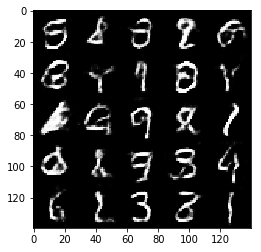

Epoch 2/2... Discriminator Loss: 0.8098... Generator Loss: 1.7215
Epoch 2/2... Discriminator Loss: 1.0934... Generator Loss: 0.7623
Epoch 2/2... Discriminator Loss: 0.8489... Generator Loss: 1.0641
Epoch 2/2... Discriminator Loss: 0.8685... Generator Loss: 1.3684
Epoch 2/2... Discriminator Loss: 0.7382... Generator Loss: 1.4444
Epoch 2/2... Discriminator Loss: 0.8523... Generator Loss: 1.7317
Epoch 2/2... Discriminator Loss: 0.8541... Generator Loss: 1.8186
Epoch 2/2... Discriminator Loss: 0.9981... Generator Loss: 0.8370
Epoch 2/2... Discriminator Loss: 0.9266... Generator Loss: 2.1684
Epoch 2/2... Discriminator Loss: 0.8491... Generator Loss: 1.0762


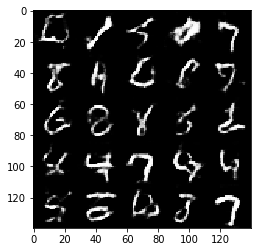

Epoch 2/2... Discriminator Loss: 0.8664... Generator Loss: 1.1801
Epoch 2/2... Discriminator Loss: 1.0184... Generator Loss: 0.8455
Epoch 2/2... Discriminator Loss: 0.8325... Generator Loss: 1.1751
Epoch 2/2... Discriminator Loss: 0.7832... Generator Loss: 1.5386
Epoch 2/2... Discriminator Loss: 1.6406... Generator Loss: 3.4080
Epoch 2/2... Discriminator Loss: 0.7398... Generator Loss: 1.4249
Epoch 2/2... Discriminator Loss: 0.7902... Generator Loss: 1.6994
Epoch 2/2... Discriminator Loss: 0.9352... Generator Loss: 0.9122
Epoch 2/2... Discriminator Loss: 0.6938... Generator Loss: 1.6275
Epoch 2/2... Discriminator Loss: 0.7105... Generator Loss: 1.4821


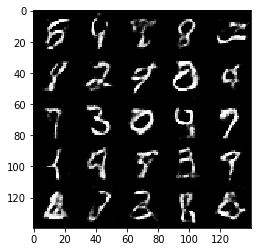

Epoch 2/2... Discriminator Loss: 0.7996... Generator Loss: 1.1240
Epoch 2/2... Discriminator Loss: 0.6661... Generator Loss: 1.6024
Epoch 2/2... Discriminator Loss: 0.8356... Generator Loss: 1.2166
Epoch 2/2... Discriminator Loss: 0.8645... Generator Loss: 1.0821
Epoch 2/2... Discriminator Loss: 0.7426... Generator Loss: 1.3111
Epoch 2/2... Discriminator Loss: 0.7143... Generator Loss: 1.4276
Epoch 2/2... Discriminator Loss: 0.8005... Generator Loss: 1.2516
Epoch 2/2... Discriminator Loss: 1.2988... Generator Loss: 2.9804
Epoch 2/2... Discriminator Loss: 0.6851... Generator Loss: 1.4033
Epoch 2/2... Discriminator Loss: 0.7390... Generator Loss: 1.3545


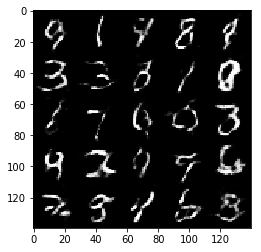

Epoch 2/2... Discriminator Loss: 0.6346... Generator Loss: 1.6843
Epoch 2/2... Discriminator Loss: 0.7447... Generator Loss: 1.6766
Epoch 2/2... Discriminator Loss: 0.9377... Generator Loss: 2.0388
Epoch 2/2... Discriminator Loss: 0.7507... Generator Loss: 1.3702
Epoch 2/2... Discriminator Loss: 0.7100... Generator Loss: 1.5224
Epoch 2/2... Discriminator Loss: 0.6876... Generator Loss: 1.7698
Epoch 2/2... Discriminator Loss: 0.7991... Generator Loss: 1.2281
Epoch 2/2... Discriminator Loss: 0.8093... Generator Loss: 1.9401
Epoch 2/2... Discriminator Loss: 0.6946... Generator Loss: 1.4810
Epoch 2/2... Discriminator Loss: 0.6995... Generator Loss: 1.7612


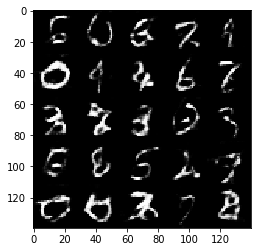

Epoch 2/2... Discriminator Loss: 0.7650... Generator Loss: 1.4289
Epoch 2/2... Discriminator Loss: 0.9665... Generator Loss: 2.1873
Epoch 2/2... Discriminator Loss: 1.2045... Generator Loss: 0.8104
Epoch 2/2... Discriminator Loss: 0.7540... Generator Loss: 1.2623
Epoch 2/2... Discriminator Loss: 0.7775... Generator Loss: 1.3445
Epoch 2/2... Discriminator Loss: 0.7258... Generator Loss: 1.5377
Epoch 2/2... Discriminator Loss: 0.7352... Generator Loss: 1.5228
Epoch 2/2... Discriminator Loss: 0.7180... Generator Loss: 1.3827
Epoch 2/2... Discriminator Loss: 0.6725... Generator Loss: 1.7328
Epoch 2/2... Discriminator Loss: 1.0058... Generator Loss: 0.8483


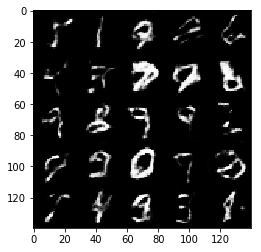

Epoch 2/2... Discriminator Loss: 0.7684... Generator Loss: 1.4185
Epoch 2/2... Discriminator Loss: 0.7463... Generator Loss: 1.4941
Epoch 2/2... Discriminator Loss: 0.7438... Generator Loss: 1.3185
Epoch 2/2... Discriminator Loss: 0.7934... Generator Loss: 1.3228
Epoch 2/2... Discriminator Loss: 0.8283... Generator Loss: 1.1633
Epoch 2/2... Discriminator Loss: 0.8147... Generator Loss: 1.9221
Epoch 2/2... Discriminator Loss: 0.7075... Generator Loss: 1.8649


In [206]:

batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6538... Generator Loss: 1.6732
Epoch 1/1... Discriminator Loss: 0.6193... Generator Loss: 2.0992
Epoch 1/1... Discriminator Loss: 0.6674... Generator Loss: 1.6104
Epoch 1/1... Discriminator Loss: 0.8407... Generator Loss: 1.6553
Epoch 1/1... Discriminator Loss: 0.7920... Generator Loss: 1.5494
Epoch 1/1... Discriminator Loss: 0.9163... Generator Loss: 3.1442
Epoch 1/1... Discriminator Loss: 1.8576... Generator Loss: 0.3270
Epoch 1/1... Discriminator Loss: 1.0584... Generator Loss: 0.9833
Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 2.8620
Epoch 1/1... Discriminator Loss: 1.1060... Generator Loss: 0.8522


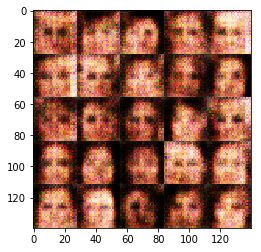

Epoch 1/1... Discriminator Loss: 0.9444... Generator Loss: 2.8904
Epoch 1/1... Discriminator Loss: 0.9769... Generator Loss: 1.1212
Epoch 1/1... Discriminator Loss: 0.9020... Generator Loss: 1.2653
Epoch 1/1... Discriminator Loss: 0.7316... Generator Loss: 2.8397
Epoch 1/1... Discriminator Loss: 1.5879... Generator Loss: 0.4365
Epoch 1/1... Discriminator Loss: 0.9443... Generator Loss: 1.6120
Epoch 1/1... Discriminator Loss: 1.1275... Generator Loss: 1.3835
Epoch 1/1... Discriminator Loss: 1.1481... Generator Loss: 2.0121
Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 1.4023
Epoch 1/1... Discriminator Loss: 1.0555... Generator Loss: 1.5196


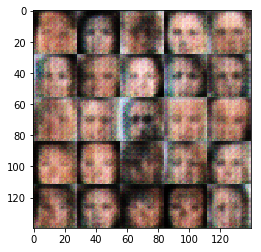

Epoch 1/1... Discriminator Loss: 0.7803... Generator Loss: 1.5513
Epoch 1/1... Discriminator Loss: 0.7238... Generator Loss: 1.6608
Epoch 1/1... Discriminator Loss: 0.9390... Generator Loss: 0.9690
Epoch 1/1... Discriminator Loss: 0.7967... Generator Loss: 1.3246
Epoch 1/1... Discriminator Loss: 1.0493... Generator Loss: 1.6903
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 4.6223
Epoch 1/1... Discriminator Loss: 1.0087... Generator Loss: 0.9453
Epoch 1/1... Discriminator Loss: 1.0787... Generator Loss: 0.8131
Epoch 1/1... Discriminator Loss: 0.8597... Generator Loss: 2.2161


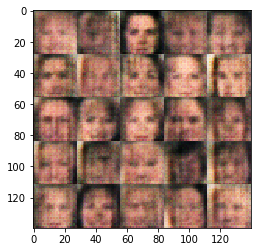

Epoch 1/1... Discriminator Loss: 1.0543... Generator Loss: 0.9247
Epoch 1/1... Discriminator Loss: 0.7198... Generator Loss: 1.3897
Epoch 1/1... Discriminator Loss: 1.1762... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.6882... Generator Loss: 0.4592
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.5726
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.5829... Generator Loss: 0.4333
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 1.0350


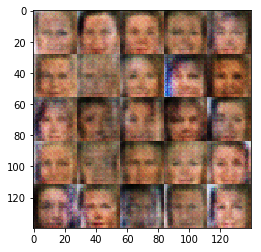

Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 1.7392
Epoch 1/1... Discriminator Loss: 1.5245... Generator Loss: 1.8391
Epoch 1/1... Discriminator Loss: 1.0684... Generator Loss: 0.8861
Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 0.9278
Epoch 1/1... Discriminator Loss: 1.1589... Generator Loss: 0.8426
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.6084
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 1.5123
Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 1.3710
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.6108


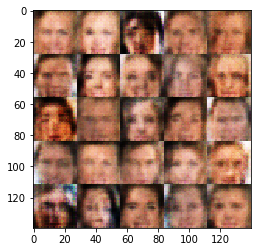

Epoch 1/1... Discriminator Loss: 1.0467... Generator Loss: 1.1399
Epoch 1/1... Discriminator Loss: 1.1430... Generator Loss: 1.0993
Epoch 1/1... Discriminator Loss: 1.5005... Generator Loss: 0.4803
Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 0.9285
Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 1.0380
Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 1.0523
Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 1.1855
Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 1.3322
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 1.7200
Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 0.8572


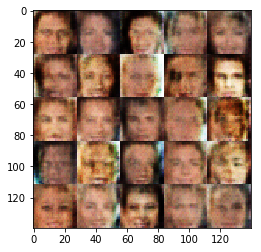

Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 1.1615
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 1.6237... Generator Loss: 0.4365
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 1.3498
Epoch 1/1... Discriminator Loss: 1.0908... Generator Loss: 1.1917
Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 1.6999
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 1.0194
Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.7608


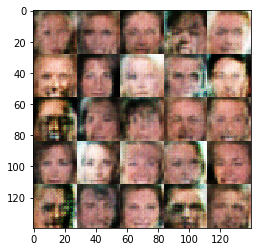

Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.9910
Epoch 1/1... Discriminator Loss: 1.6505... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.1098... Generator Loss: 0.9351
Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 0.9538
Epoch 1/1... Discriminator Loss: 1.1132... Generator Loss: 1.6537
Epoch 1/1... Discriminator Loss: 1.1345... Generator Loss: 1.0737
Epoch 1/1... Discriminator Loss: 1.0205... Generator Loss: 1.1299
Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 1.1927
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 0.9560
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 1.3691


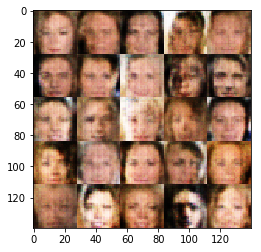

Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 1.7202
Epoch 1/1... Discriminator Loss: 1.1853... Generator Loss: 1.1395
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.8510
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 1.4265
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 0.8735... Generator Loss: 2.1270
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 1.4623
Epoch 1/1... Discriminator Loss: 1.0932... Generator Loss: 1.0107
Epoch 1/1... Discriminator Loss: 1.0574... Generator Loss: 0.9814


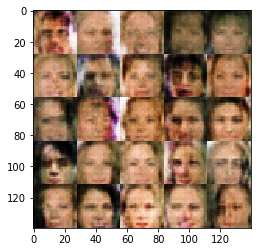

Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.6367
Epoch 1/1... Discriminator Loss: 1.0267... Generator Loss: 1.1566
Epoch 1/1... Discriminator Loss: 1.0164... Generator Loss: 1.8299
Epoch 1/1... Discriminator Loss: 1.5179... Generator Loss: 2.7291
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 0.8677
Epoch 1/1... Discriminator Loss: 0.9489... Generator Loss: 1.5446
Epoch 1/1... Discriminator Loss: 1.1429... Generator Loss: 1.0022
Epoch 1/1... Discriminator Loss: 1.2563... Generator Loss: 0.8854
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 1.4955
Epoch 1/1... Discriminator Loss: 1.1029... Generator Loss: 1.4193


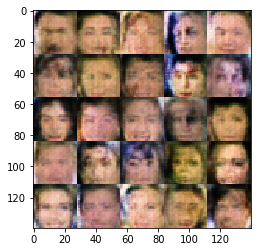

Epoch 1/1... Discriminator Loss: 1.0225... Generator Loss: 1.1024
Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 1.7761
Epoch 1/1... Discriminator Loss: 1.1212... Generator Loss: 0.8432
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 1.0529
Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 1.2056
Epoch 1/1... Discriminator Loss: 1.6655... Generator Loss: 2.5737
Epoch 1/1... Discriminator Loss: 1.0426... Generator Loss: 1.0375
Epoch 1/1... Discriminator Loss: 1.1640... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 0.9417... Generator Loss: 1.0994


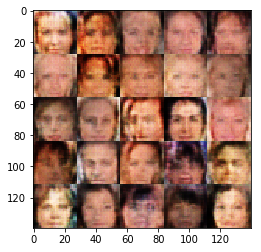

Epoch 1/1... Discriminator Loss: 0.7170... Generator Loss: 1.6870
Epoch 1/1... Discriminator Loss: 1.0169... Generator Loss: 0.9321
Epoch 1/1... Discriminator Loss: 0.9668... Generator Loss: 0.9616
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.8942
Epoch 1/1... Discriminator Loss: 1.1593... Generator Loss: 0.9118
Epoch 1/1... Discriminator Loss: 1.0765... Generator Loss: 0.8771
Epoch 1/1... Discriminator Loss: 0.7910... Generator Loss: 1.3468
Epoch 1/1... Discriminator Loss: 0.8544... Generator Loss: 1.6036
Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 0.9067


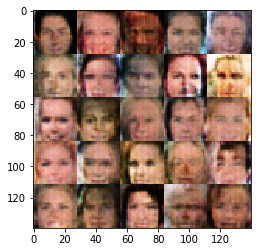

Epoch 1/1... Discriminator Loss: 1.5726... Generator Loss: 0.4522
Epoch 1/1... Discriminator Loss: 1.0873... Generator Loss: 1.2779
Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 0.9927
Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 1.0906
Epoch 1/1... Discriminator Loss: 0.7976... Generator Loss: 1.8415
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.4792
Epoch 1/1... Discriminator Loss: 1.0630... Generator Loss: 1.6040
Epoch 1/1... Discriminator Loss: 0.9423... Generator Loss: 1.6103
Epoch 1/1... Discriminator Loss: 1.0780... Generator Loss: 0.8766
Epoch 1/1... Discriminator Loss: 0.9920... Generator Loss: 1.7363


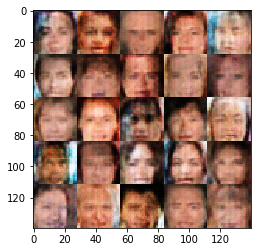

Epoch 1/1... Discriminator Loss: 0.9859... Generator Loss: 2.4187
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 2.0835
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.5055
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 0.8660
Epoch 1/1... Discriminator Loss: 0.7801... Generator Loss: 1.5581
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.4958
Epoch 1/1... Discriminator Loss: 0.8938... Generator Loss: 1.0127
Epoch 1/1... Discriminator Loss: 1.0142... Generator Loss: 1.2879
Epoch 1/1... Discriminator Loss: 0.9862... Generator Loss: 0.9957
Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 0.6985


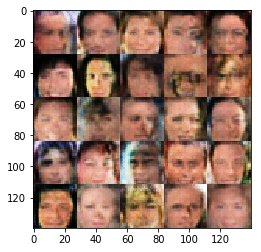

Epoch 1/1... Discriminator Loss: 0.8552... Generator Loss: 1.6608
Epoch 1/1... Discriminator Loss: 1.0532... Generator Loss: 0.9777
Epoch 1/1... Discriminator Loss: 0.8359... Generator Loss: 1.6225
Epoch 1/1... Discriminator Loss: 0.9177... Generator Loss: 1.3101
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 1.1718
Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 0.8891
Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.6024
Epoch 1/1... Discriminator Loss: 0.7986... Generator Loss: 1.3020


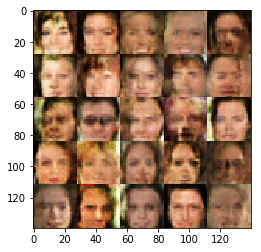

Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.5503
Epoch 1/1... Discriminator Loss: 1.1879... Generator Loss: 0.9032
Epoch 1/1... Discriminator Loss: 1.6988... Generator Loss: 0.3397
Epoch 1/1... Discriminator Loss: 0.6474... Generator Loss: 1.9928
Epoch 1/1... Discriminator Loss: 0.9958... Generator Loss: 0.8436
Epoch 1/1... Discriminator Loss: 1.2487... Generator Loss: 0.6216
Epoch 1/1... Discriminator Loss: 0.9951... Generator Loss: 0.8703
Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 2.0847
Epoch 1/1... Discriminator Loss: 1.0799... Generator Loss: 1.1975
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 0.6130


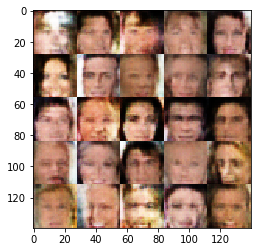

Epoch 1/1... Discriminator Loss: 1.4939... Generator Loss: 0.4476
Epoch 1/1... Discriminator Loss: 0.8759... Generator Loss: 1.3879
Epoch 1/1... Discriminator Loss: 1.0108... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 0.8402... Generator Loss: 1.2523
Epoch 1/1... Discriminator Loss: 0.9149... Generator Loss: 1.9677
Epoch 1/1... Discriminator Loss: 0.8830... Generator Loss: 2.5785
Epoch 1/1... Discriminator Loss: 1.0107... Generator Loss: 1.6496
Epoch 1/1... Discriminator Loss: 0.8073... Generator Loss: 1.3220
Epoch 1/1... Discriminator Loss: 2.1346... Generator Loss: 0.2155
Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 0.5983


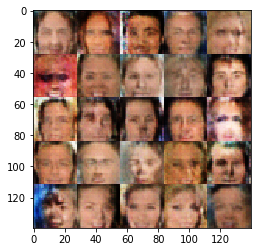

Epoch 1/1... Discriminator Loss: 0.7143... Generator Loss: 1.9257
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 1.0613
Epoch 1/1... Discriminator Loss: 1.2912... Generator Loss: 3.7390
Epoch 1/1... Discriminator Loss: 0.8069... Generator Loss: 2.0146
Epoch 1/1... Discriminator Loss: 0.9893... Generator Loss: 1.0235
Epoch 1/1... Discriminator Loss: 0.7961... Generator Loss: 1.6443
Epoch 1/1... Discriminator Loss: 0.7446... Generator Loss: 1.4626
Epoch 1/1... Discriminator Loss: 1.1549... Generator Loss: 3.5466
Epoch 1/1... Discriminator Loss: 1.0287... Generator Loss: 1.1494
Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 1.1709


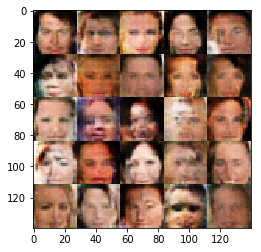

Epoch 1/1... Discriminator Loss: 0.8719... Generator Loss: 1.0582
Epoch 1/1... Discriminator Loss: 0.9409... Generator Loss: 1.0543
Epoch 1/1... Discriminator Loss: 1.1749... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 0.7332... Generator Loss: 1.3801
Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 1.0063
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 0.6481
Epoch 1/1... Discriminator Loss: 0.8493... Generator Loss: 1.8445
Epoch 1/1... Discriminator Loss: 0.9833... Generator Loss: 1.0686


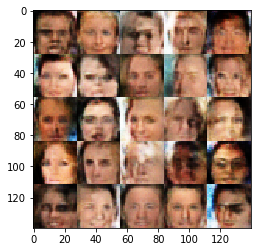

Epoch 1/1... Discriminator Loss: 1.1862... Generator Loss: 1.0133
Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 0.8331... Generator Loss: 1.2556
Epoch 1/1... Discriminator Loss: 1.0233... Generator Loss: 1.3105
Epoch 1/1... Discriminator Loss: 0.8629... Generator Loss: 1.1084
Epoch 1/1... Discriminator Loss: 0.9837... Generator Loss: 1.0985
Epoch 1/1... Discriminator Loss: 0.9500... Generator Loss: 1.3194
Epoch 1/1... Discriminator Loss: 1.0141... Generator Loss: 1.0594
Epoch 1/1... Discriminator Loss: 1.0122... Generator Loss: 1.0342
Epoch 1/1... Discriminator Loss: 0.8121... Generator Loss: 1.1854


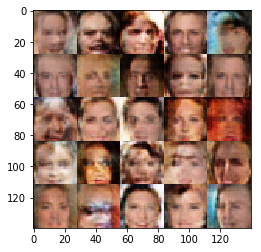

Epoch 1/1... Discriminator Loss: 0.9180... Generator Loss: 1.4770
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.4803
Epoch 1/1... Discriminator Loss: 1.1069... Generator Loss: 0.9622
Epoch 1/1... Discriminator Loss: 0.8937... Generator Loss: 1.3786
Epoch 1/1... Discriminator Loss: 0.9167... Generator Loss: 1.7746
Epoch 1/1... Discriminator Loss: 0.8292... Generator Loss: 1.6169
Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 1.5226
Epoch 1/1... Discriminator Loss: 0.8312... Generator Loss: 1.7640
Epoch 1/1... Discriminator Loss: 1.0780... Generator Loss: 1.0890
Epoch 1/1... Discriminator Loss: 1.0468... Generator Loss: 0.9078


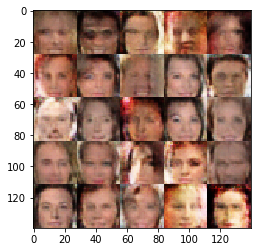

Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 0.4685
Epoch 1/1... Discriminator Loss: 0.8799... Generator Loss: 1.5490
Epoch 1/1... Discriminator Loss: 0.8418... Generator Loss: 1.3393
Epoch 1/1... Discriminator Loss: 0.9552... Generator Loss: 2.1788
Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 0.6114
Epoch 1/1... Discriminator Loss: 0.9098... Generator Loss: 1.2455
Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.5642
Epoch 1/1... Discriminator Loss: 1.1006... Generator Loss: 0.8624
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.5246
Epoch 1/1... Discriminator Loss: 0.9228... Generator Loss: 1.8189


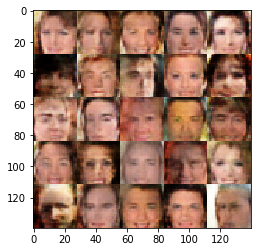

Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 0.6997
Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.1673... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 0.9259... Generator Loss: 1.1053
Epoch 1/1... Discriminator Loss: 0.9851... Generator Loss: 1.9867
Epoch 1/1... Discriminator Loss: 1.0208... Generator Loss: 1.2228
Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 1.0716
Epoch 1/1... Discriminator Loss: 0.8932... Generator Loss: 1.1312
Epoch 1/1... Discriminator Loss: 1.0162... Generator Loss: 0.9961
Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 1.1872


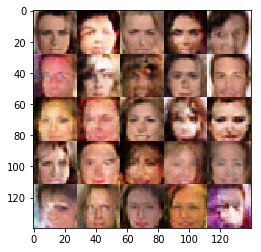

Epoch 1/1... Discriminator Loss: 1.5309... Generator Loss: 0.4220
Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 0.9674
Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 1.0675
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 0.6250
Epoch 1/1... Discriminator Loss: 1.0193... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.1580... Generator Loss: 1.0933
Epoch 1/1... Discriminator Loss: 0.9729... Generator Loss: 1.1355
Epoch 1/1... Discriminator Loss: 0.9289... Generator Loss: 1.0896
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.5265
Epoch 1/1... Discriminator Loss: 1.0519... Generator Loss: 1.1337


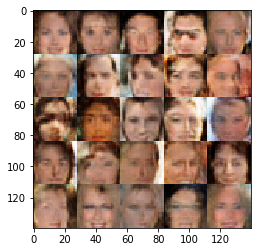

Epoch 1/1... Discriminator Loss: 0.9689... Generator Loss: 0.9918
Epoch 1/1... Discriminator Loss: 0.9392... Generator Loss: 1.1993
Epoch 1/1... Discriminator Loss: 0.9223... Generator Loss: 1.0124
Epoch 1/1... Discriminator Loss: 1.0612... Generator Loss: 1.1825
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 1.1836
Epoch 1/1... Discriminator Loss: 0.8649... Generator Loss: 1.3660
Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 0.9599... Generator Loss: 1.2836
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 0.8842... Generator Loss: 1.0234


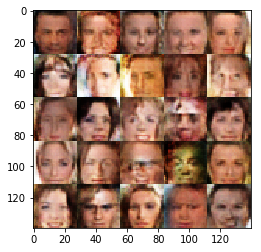

Epoch 1/1... Discriminator Loss: 1.0956... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 0.8152... Generator Loss: 1.7998
Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 1.2165
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 1.5763
Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 0.8549
Epoch 1/1... Discriminator Loss: 1.0614... Generator Loss: 0.8676
Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 0.6623
Epoch 1/1... Discriminator Loss: 1.0565... Generator Loss: 0.8454
Epoch 1/1... Discriminator Loss: 1.0319... Generator Loss: 1.2461
Epoch 1/1... Discriminator Loss: 0.9898... Generator Loss: 1.0050


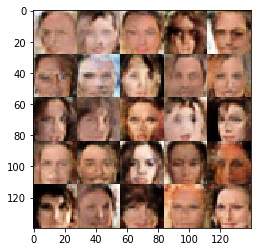

Epoch 1/1... Discriminator Loss: 0.9043... Generator Loss: 1.1909
Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 0.9589... Generator Loss: 1.1146
Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 0.5896
Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 1.6349
Epoch 1/1... Discriminator Loss: 0.9101... Generator Loss: 1.2129
Epoch 1/1... Discriminator Loss: 1.2024... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.1503... Generator Loss: 0.7842


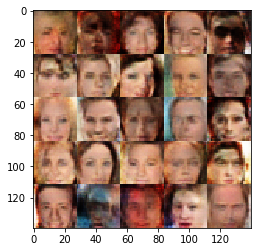

Epoch 1/1... Discriminator Loss: 0.9648... Generator Loss: 0.9810
Epoch 1/1... Discriminator Loss: 1.0276... Generator Loss: 1.0164
Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.5450
Epoch 1/1... Discriminator Loss: 0.9894... Generator Loss: 1.1358
Epoch 1/1... Discriminator Loss: 1.0241... Generator Loss: 1.4996
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.4837
Epoch 1/1... Discriminator Loss: 1.0201... Generator Loss: 1.0422
Epoch 1/1... Discriminator Loss: 1.0520... Generator Loss: 0.9060
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 0.8408


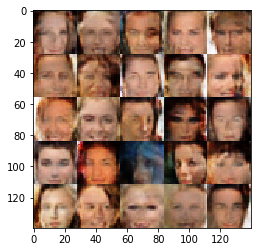

Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 1.2512
Epoch 1/1... Discriminator Loss: 1.4709... Generator Loss: 0.4428
Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.0764... Generator Loss: 1.0128
Epoch 1/1... Discriminator Loss: 1.1974... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 0.8154... Generator Loss: 1.5788
Epoch 1/1... Discriminator Loss: 1.0209... Generator Loss: 2.1902
Epoch 1/1... Discriminator Loss: 0.9310... Generator Loss: 1.3455
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.5759
Epoch 1/1... Discriminator Loss: 1.0471... Generator Loss: 0.8312


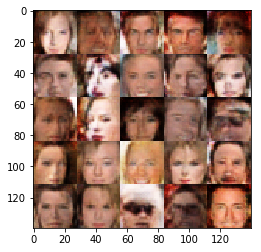

Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 0.5804
Epoch 1/1... Discriminator Loss: 1.1180... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 0.9922... Generator Loss: 1.0962
Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 0.5914
Epoch 1/1... Discriminator Loss: 0.9913... Generator Loss: 1.1137
Epoch 1/1... Discriminator Loss: 0.9110... Generator Loss: 1.5998
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 0.9210
Epoch 1/1... Discriminator Loss: 0.7240... Generator Loss: 1.3948
Epoch 1/1... Discriminator Loss: 1.0033... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 1.1163... Generator Loss: 0.7098


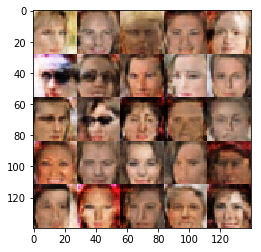

Epoch 1/1... Discriminator Loss: 0.8092... Generator Loss: 1.8430
Epoch 1/1... Discriminator Loss: 1.1008... Generator Loss: 0.8806
Epoch 1/1... Discriminator Loss: 1.0749... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.1444... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.0456... Generator Loss: 1.1589
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.0723... Generator Loss: 1.0015
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 0.8771
Epoch 1/1... Discriminator Loss: 0.9323... Generator Loss: 0.9851


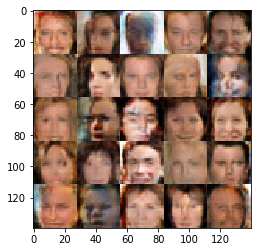

Epoch 1/1... Discriminator Loss: 0.8071... Generator Loss: 1.6186
Epoch 1/1... Discriminator Loss: 1.0132... Generator Loss: 1.0182
Epoch 1/1... Discriminator Loss: 0.8941... Generator Loss: 1.2864
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 1.9772
Epoch 1/1... Discriminator Loss: 1.1858... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 0.9489... Generator Loss: 0.9993


In [207]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.